In [6]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0
    
    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)
    
if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

In [7]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [10]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
    
    return features, labels

In [15]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}. {} is out of range.'.format(len(features), batch_id, sample_id))
        return None
    
    print('\nStats of batch #{}:'.format(batch_id))
    print('# of samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
        
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of images {}:'.format(sample_id))
    print('Images - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label ID: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)
        


Stats of batch #3:
# of samples: 10000

Label counts of [0](AIRPLANE) : 994
Label counts of [1](AUTOMOBILE) : 1042
Label counts of [2](BIRD) : 965
Label counts of [3](CAT) : 997
Label counts of [4](DEER) : 990
Label counts of [5](DOG) : 1029
Label counts of [6](FROG) : 978
Label counts of [7](HORSE) : 1015
Label counts of [8](SHIP) : 961
Label counts of [9](TRUCK) : 1029

Example of images 7000:
Images - Min Value: 24 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label ID: 0 Name: airplane


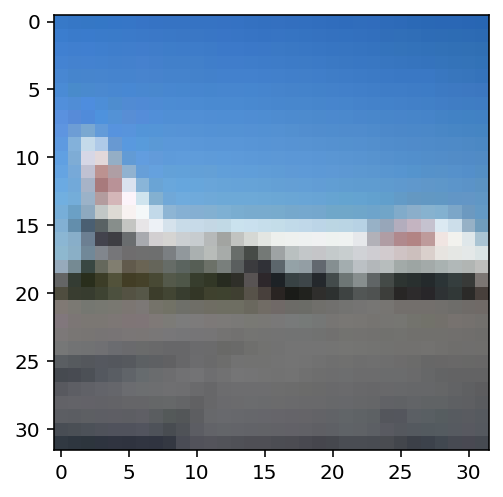

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

batch_id = 3
sample_id = 7000
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [17]:
def normalize(x):
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [18]:
def one_hot_encode(x):
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

In [21]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)
    
    pickle.dump((features, labels), open(filename, 'wb'))
    
def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []
    
    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        index_of_validation = int(len(features) * 0.1)
        
        _preprocess_and_save(normalize, one_hot_encode,
                            features[:-index_of_validation], labels[:-index_of_validation],
                            'preprocess_batch_' + str(batch_i) + '.p')
        
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])
        
        _preprocess_and_save(normalize, one_hot_encode,
                            np.array(valid_features), np.array(valid_labels),
                            'preprocess_validation.p')
        
        with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
            batch = pickle.load(file, encoding='latin1')
        
        test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
        test_labels = batch['labels']
        
        _preprocess_and_save(normalize, one_hot_encode,
                            np.array(test_features), np.array(test_labels),
                            'preprocess_training.p')

In [22]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [33]:
import pickle

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [34]:
import tensorflow as tf
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

AttributeError: module 'tensorflow' has no attribute 'reset_default_graph'